In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import matplotlib as mpl
import numpy as np
import math
import pickle
import os

/tmp/ipykernel_2225/1444662633.py:156: RuntimeWarning: divide by zero encountered in log10
  kari2=20*np.log10(abs(ifSgat))


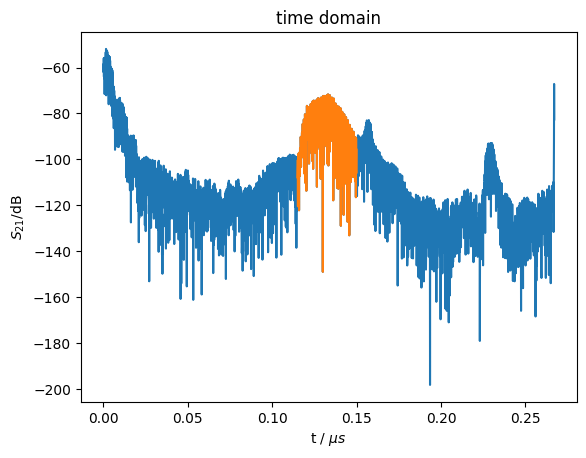

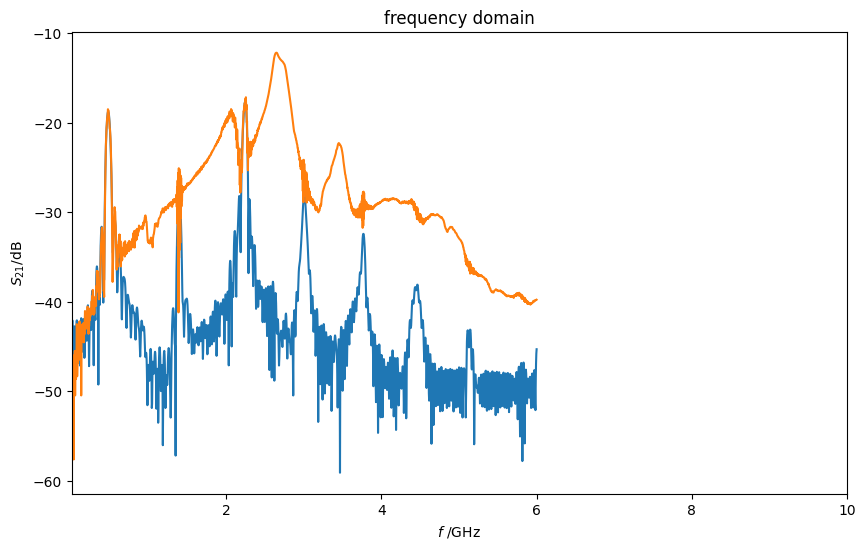

4019.382810507524
j= 0


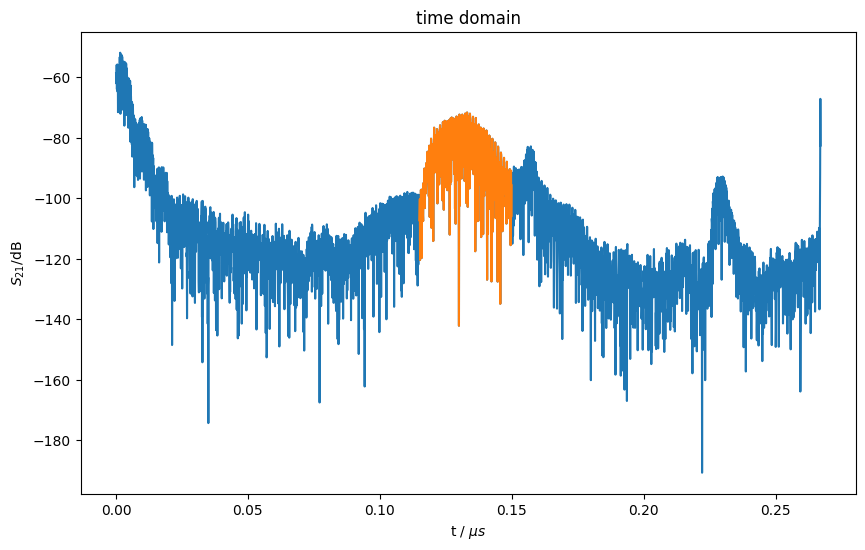

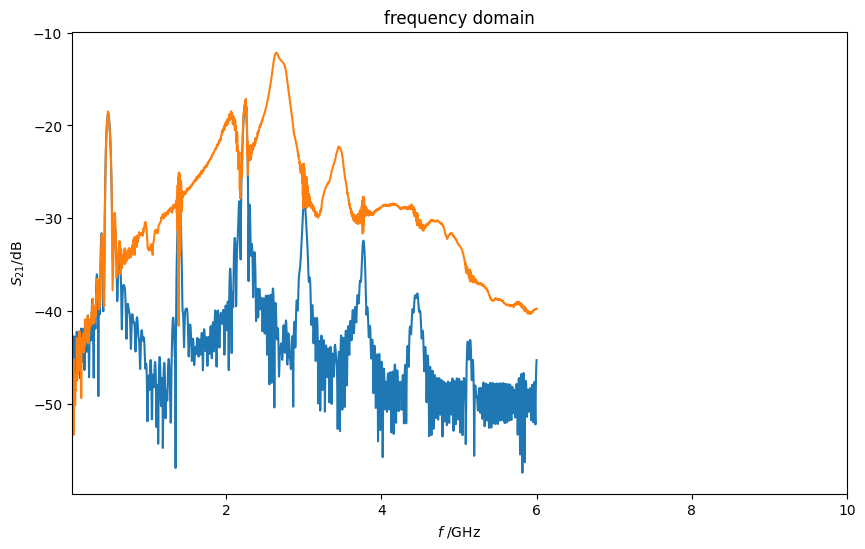

4019.382810507524
j= 1


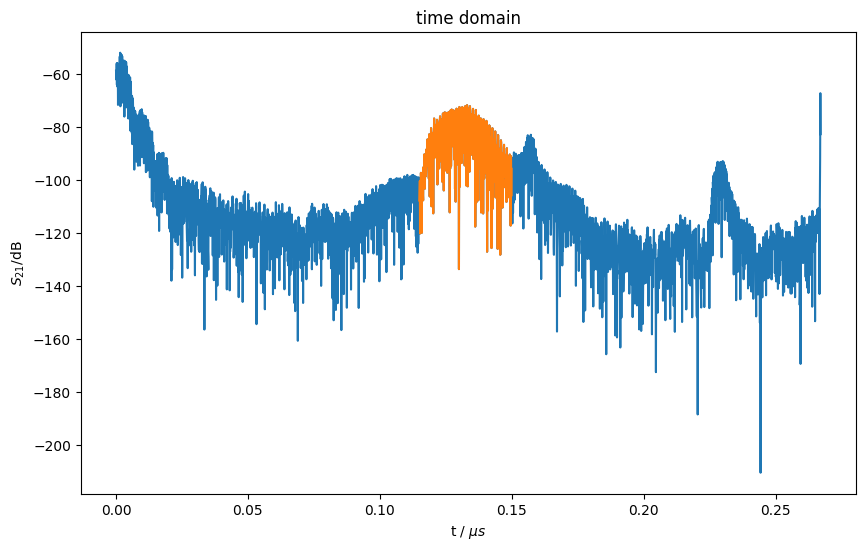

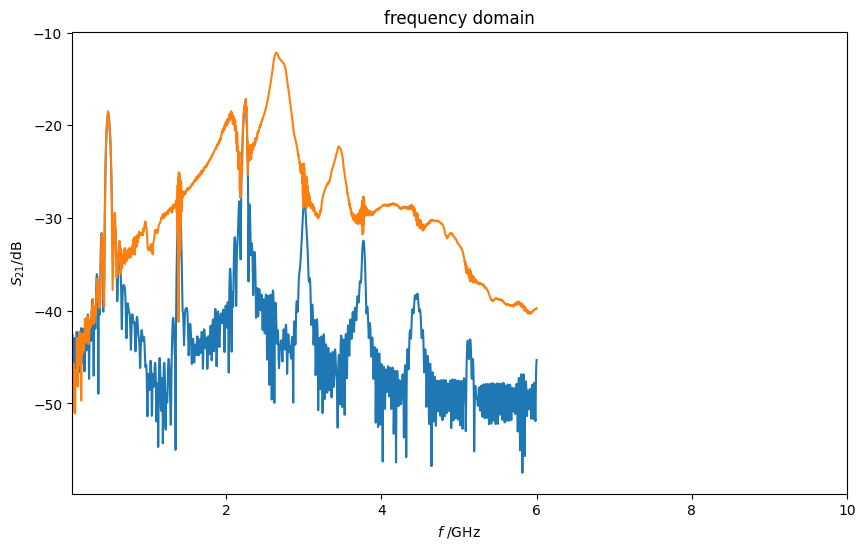

4019.382810507524
j= 2


In [2]:
#-----tracedata---------------------------------------------------------
#データの読み込み
switch_trace = False #事前にメモリしたtracedataとのベクトル差を作りたいときはこっちをTrueにする
#ただし、ifft前に周波数信号のジャンプを取り除くために窓関数を掛けたりしていないし、折り返しのやり方も下と異なる不完全な部分なのでココを使いたくなったら次のセクションを参考に直して下さい。
if switch_trace:
    Real = np.genfromtxt("Real_mem.txt") #重要！このデータは電圧比を表していて無次元です。同時にVNAがはき出すLogMagというデータはもちろんdB単位になっています。
    Imag = np.genfromtxt("Img_mem.txt")
    freq = np.genfromtxt("freq0.txt")
    
    #Sパラメータと絶対値を計算
    Strace = Real + Imag*1j #Sパラメータ
    Magtrace = abs(Strace) #絶対値
    
    #フーリエ変換のために周波数を0GHzからにして折り返す。折り返すのは精度を確保するため。折り返した部分は複素共役にする
    #参考：https://mashiroyuya.hatenablog.com/entry/ifftpython
    df = freq[1]-freq[0]
    offset = np.floor(freq[0]/df)
    F0 = []
    n = int(2*len(freq) + 2*offset + 1)
    for i in range(n): #周波数帯を0GHｚからにして折り返した分と中央の0
        if i < len(freq):
            F0.append(Strace[len(freq)- i - 1].conjugate())
        elif i > int(len(freq) + 2*offset):
            F0.append(Strace[i-(len(freq) + 2*int(offset) + 1)])
        else:
            F0.append(0)
    F = np.array(F0) #Numpy配列化

    #ifftでtimedomainにしたときの横軸容易
    #t = 2*np.arange(2*len(freq) + 2*int(offset) + 1)/(df*2.0*(2*len(freq) + 2*offset + 1))
    t = np.arange(2*len(freq) + 2*int(offset) + 1)

#ifft
    f0 = np.fft.ifft(F)

    #最初に到達した表面弾性波だけで切り取り
    for i in range(n):
        if (i > 323) and (i < 973):
            f0[i] = f0[i]
        else:
            f0[i] = 0

#fft
    fafter = np.fft.fft(f0)
    Strace_reduction = fafter[n-len(freq):n]
    Magtrace_reduction = abs(Strace_reduction)
#-----tracedata------------------------------------------------------------
Real = np.genfromtxt("Real_data0_0.txt")
#-----Spara---------
switch_DeltaP = True
if switch_DeltaP:#switch
    Pin=10**(-5/10)*1e-3 #入射電力は-5dBmに設定。ここでは単位をWに直す。
    #角度依存性で切る
    for i in range(1): #0°～360°まで37測定分の解析
        Real = np.genfromtxt("Real_data0_0.txt")
        Imag = np.genfromtxt("Imag_data0_0.txt")
        field = np.genfromtxt("gaussX_0_0.txt")
        freq = np.genfromtxt("freq0.txt")

        #変数の設定
        Nfreq=len(freq)
        Nfield=len(field)
        N_Sreal=len(Real[:,0])
        N_Simag=len(Imag[:,0])

        freqmin=freq[0]#最小周波数
        freqmax=freq[Nfreq-1]#最大周波数
        Deltaf=(freqmax-freqmin)/(Nfreq-1)

        #説明しよう！mp.linespaceとは等差数列をはき出す関数である
        #ここではifftを施すために、周波数配列の区間を0からにし、後でifft後の精度を確保するための折り返しを行う準備をする
        #折り返すといっても、0GHzのところで折り返すわけではない
        f0=np.linspace(0, freqmin, num = int(freqmin/Deltaf), endpoint = True, retstep = False, dtype = None) 
        f=np.append(f0,freq)
        fturn=np.linspace(freqmax, freqmax*2, num = len(f), endpoint = True, retstep = False, dtype = None)
        f2=np.append(f,fturn) 

        Dt=1/np.amax(f2)#1/4GHz  4GHzはサンプリング周波数
        ifT=range(0,len(f2))*Dt

#秒数でゲーティング範囲指定したいときはこっち
        gst=115e-9#gating_start
        ged=150e-9#gating_end
        X=int(gst/Dt)#gaint_startのポイント数
        Y=int(ged/Dt)#gaint_endのポイント数
#        X=2000
#        Y=5000


        zero1=np.zeros(X)#時間領域において0~X番目まで0
        zero2=np.zeros(len(f2)-Y)#Y~6402まで0


        #----------------------------------------
        #ゼロと空の配列の準備
        #----------------------------------------
        Real2=np.empty(N_Sreal)
        dfSarray1=np.empty(N_Sreal)
        dfSarray2=np.empty(N_Sreal)

#磁場の強度で切る
        for j in range(len(field)):
            Sreal =Real[:,j]
            Simag =Imag[:,j]
            Real2=np.vstack((Real2,Sreal)) #ndarrayの結合
      
            #窓関数を掛ける。
            #このままだと0~fmin GHzとfmin~fmax GHzの境でSパラメータが0から有限の値にジャンプする。
            #そのジャンプがフーリエ変換する上でノイズになるので窓関数を掛ける
            Sreal = Sreal*(0.54-0.46*np.cos(2*np.pi*(freq-freqmin)/(freqmax-freqmin)))
            Simag = Simag*(0.54-0.46*np.cos(2*np.pi*(freq-freqmin)/(freqmax-freqmin)))
            
            #Eedit
            Esum=Sreal+1j*Simag

            #周波数範囲を拡張する
            S0=np.zeros(len(f)-len(Sreal))
            SrealzeroPD=np.append(S0,Sreal)
            SimagzeroPD=np.append(S0,Simag)
            
            Ssum=SrealzeroPD+1j*SimagzeroPD
            
            #-----------------------------------------------------------------------
            #折り返し
            #-------------------------------------------------------------------------
            #詳しくはわからんのだけどfftしてできるこの信号を作ってるっぽい。だから折り返しがf=0GHz対称のものでなくfmax対称としている
            #http://exp1gw.ec.t.kanazawa-u.ac.jp/DSP/Signal-Processing/frequency-domain.html
            Sturn=np.conjugate(Ssum[::-1]) #[::a]で要素をa個毎に切り出す、今回は-1だから折り返しになる
            Ssum=np.append(Ssum,Sturn)
            
            #--------------------------------------------------
            #逆フーリエ変換
            #--------------------------------------------------
            ifS=np.fft.ifft(Ssum)
                
            #--------------------------------------------------
            #gating
            #--------------------------------------------------
            ifSgat=ifS[X:Y]
#
            ifSgat=np.append(zero1,ifSgat)
            ifSgat=np.append(ifSgat,zero2)#時間「領域においてゲーティングしたSpara
 
            #-------------------------------------------------------
            #フーリエ変換
            #-------------------------------------------------------             
            dfS=np.fft.fft(ifSgat) 
            
            #----------------------------------------------------------
            #前半,ゼロを抽出
            #-----------------------------------------------------------
            dfS=dfS[len(f0):len(f0)+len(freq)]
            
            if True:
                kari1=20*np.log10(abs(ifS))
                kari2=20*np.log10(abs(ifSgat))
#                plt.plot(range(0,len(f2)),kari1)
#                plt.plot(range(0,len(f2)),kari2)
                plt.plot(ifT*1e6,kari1)
                plt.plot(ifT*1e6,kari2)
#                plt.xlim(2300,3600)
                plt.autoscale()
            
                plt.title("time domain")
                plt.xlabel("t / ${\mu}s$ ", fontsize=10)
#                plt.xlabel("points", fontsize=10)
                plt.ylabel("$S_{21}$/dB", fontsize=10)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.rcParams["figure.figsize"] = (10, 6)
                plt.show()
                
                dfskari=Pin*abs(dfS)**2
                plt.plot(freq*1e-9,10*np.log10(abs(dfS)))
                plt.plot(freq*1e-9,10*np.log10(abs(Esum))) #Eedit
                #plt.plot(freq*1e-9,10*np.log10(dfskari)) #Eedit
                plt.rcParams["figure.figsize"] = (10, 6)
                plt.xlim([0.01,10])
                plt.title("frequency domain")
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.xlabel("$\mathit{f}$ /GHz",fontsize=10)
                plt.ylabel("$S_{21}$/dB", fontsize=10)
                plt.show()
                p_toutatsu=2320 #波が検知用IDTに到達した時間の点数
                velocity = 400e-6/(X*Dt - 61e-6/3940)
                print(velocity)
                print("j=",j)

                ep=np.argmax(dfS)
                print("num=",ep)
                print("maxfreq=",freq[ep]*1e-9)
                sep=np.argmax(dfS[:200])
                print("subnum=",sep)
                print("submaxfreq=",freq[sep]*1e-9)
                #stop
      
      
#            #---------------------------------------------------------------------
#            #窓関数を戻す
#            #---------------------------------------------------------------------      
#            dfS=dfS/(0.54-0.46*np.cos(2*np.pi*(freq-freqmin)/(freqmax-freqmin)))#gating後の周波数領域Spara
#            dfSarray2=np.vstack((dfSarray2,dfS))
#            dfSarray1=np.vstack((dfSarray1,dfSarray2[j+1]-dfSarray2[1])) 
#            
#        #--------------------------ゲーティング処理後のSpara!!!-----------------
#        dfSarray2= np.delete(dfSarray2, 0, axis=0)#gating処理後のすべてのデータ　0番目のデータはnp.emptyで作った行で0いらないから消す。
#        dfSarray1= np.delete(dfSarray1, 0, axis=0)
#
#        #---------------------------------------------------------------
#        dfSarray2_real= np.delete(dfSarray2.real, 0, axis=0)#保存用に実部を取り出す 
#        dfSarray2_imag= np.delete(dfSarray2.imag, 0, axis=0)#保存用に虚部を取り出す
#        dfS_saw=dfSarray2[0,:]#磁場0番目、トレースデータ 
#        dfS_saw_power=Pin*abs(dfS_saw)**2
#        saw_max=np.amax(dfS_saw_power)
#        
#        
#        dfS_trace=dfSarray2-dfS_saw#S-S_saw、行が周波数、列が磁場
#        P_SAW=Pin*abs(dfS_saw)**2#SAWエネルギーのS->Pに変換、配列
#        P_SAWmax=np.amax(Pin*abs(dfS_saw)**2)#P_sawの最大、値
#        DeltaPnorm = Pin*abs(dfSarray1)**2/saw_max #Eedit
#        tracedata = abs(dfSarray2[0,:])**2 
#
#
##------------------保存
#        np.savetxt("DeltaPnorm.txt", DeltaPnorm)
#        np.savetxt("tracedata.txt", tracedata)
        
            
            
            
            
        



#plt.plot(freq,Sreduction)
#plt.show()


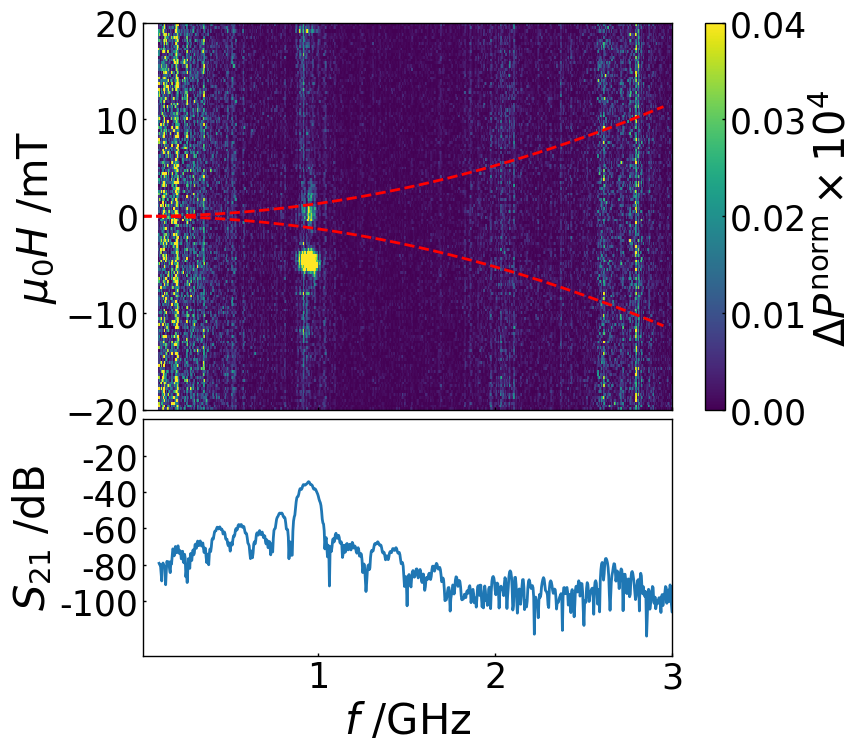

In [7]:
params = {
    #'font.family': 'Calibri', #使用するフォント名
    'mathtext.default': 'regular', #数式で通常使用するフォント．'regular'にすると数式のフォントが通常使用に設定されたフォントと同じになる
#    'font.weight': 'bold',#boldに出来る
    'font.size': 8, #全体のフォントサイズ．凡例のサイズ調整は何故かうまく動作せず．個々のフォントサイズを変えたい場合は以下を調整
    'axes.labelsize': 30, # 軸ラベルのフォントサイズ
    'legend.fontsize': 8, # 凡例の文字の大きさ
    'xtick.labelsize': 25, # x軸の数値の文字の大きさ
    'ytick.labelsize': 25, # y軸の数値の文字の大きさ
    'lines.linewidth'   : 2.0, 
    'figure.subplot.hspace' : 0.1 ,
    'figure.subplot.left'     : 0.2,
    'figure.subplot.bottom'     : 0.1,
    'figure.autolayout' : False,
    'axes.linewidth' : 1.0,
    'xtick.major.width'    : 1,
    'xtick.major.size'    : 2,
    'ytick.major.width'    : 1,
    'ytick.major.size'    : 2,
    'figure.figsize': [24.0/2.54, 24.0/2.54],
}
 
plt.rcParams.update(params)
#mpl.rcParams['pdf.fonttype'] = 42

gyoave=1
retuave=1

load = True
if load:
    POWERdata= np.genfromtxt("DeltaPnorm.txt")
#    POWERdata= np.genfromtxt("@traceV5_typeB_normalized_sattelite.txt")
    tracedata= np.genfromtxt("tracedata.txt")
#    tracedata=POWERdata[0,:]
    freq= np.genfromtxt("freq0.txt")
    field= np.genfromtxt("gaussX_0_0.txt")
#    field= np.delete(field, 0, axis=0)

#   gauss=-0.0325223+0.189416*field-0.000494966*field**2+0.000536273*field**3+0.000418497*field**4-7.95163e-5*field**5-5.38487e-5*field**6+3.22656e-6*field**7+2.79955e-6*field**8-5.36458e-8*field**9-4.82089e-8*field**10
#　上の式はSAW用プローバーにおける磁場校正の式、下は知らん
#    gauss=gauss*100-1.63884
#    gauss=-3.1085+13.361*field-1.5152*field**2+0.7780*field**3+11.439*field**4-21.788*field**5+11.375*field**6
    

    freq=freq*1e-9
#    gauss=gauss*1e+2-1.169
    gauss=field-1.3
#定数部分はオフセット分（電磁石への入力電圧を0にしたときに残る磁場)

#gauss = gauss[::-1]
gauss.sort()


#from guiqwt.builder import make
#def imshow(win, x, y, data, yreverse=False, title=None):
#    image = make.xyimage(x, y, data, interpolation="nearest", title=title )
#    plot = win.get_plot()
#    plot.add_item(image)
#    plot.do_autoscale()
#    plot.replot()
    
#    return plot, image



#from guiqwt.plot import ImageDialog
#import guidata
#_app = guidata.qapplication()



plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
X, Y = np.meshgrid(freq,gauss)
Z = POWERdata*1e4
plt.subplots_adjust(wspace=100,hspace=100)
ax1=plt.subplot(1, 1, 1)
#plt.pcolor(X, Y, Z, cmap='rainbow')
plt.pcolor(X, Y, Z)
plt.colorbar(shrink=1,label='$\Delta \mathit{P}^{norm} \\times 10^{4}$ ')
#plt.xlabel("$\mathit{f}$ /GHz",fontsize=30)
plt.ylabel("$\mathit{\mu}_{0}\mathit{H}$ /mT",fontsize=30)
plt.ylim([-20,20])
plt.xlim([0.01,3])
plt.clim(0, 0.04) 
#plt.text(1.2,7,"750 nm Pt(40)",fontsize=50,color="white")
#750 nmだけなら１．５３５でよい
#plt.yticks([-6,-4,-2,0,2,4,6], ["-6","-4","-2","0","2","4","6"])
#plt.clim(vmin=0,vmax=40.549) 
#plt.setp(ax1.get_xticklabels(), visible=False)
plt.tick_params(labelbottom=False, labelleft=True)

#x = np.arange(-10 ,-4 , 0.05)
#plt.plot(x-x+1.604978125,x,color='cyan',linestyle="dashed")
#x = np.arange(-3 ,3.5 , 0.05)
#plt.plot(x-x+1.604978125,x,color='cyan',linestyle="dashed",label='SAW')
#x = np.arange(4.5 ,10 , 0.05)
#plt.plot(x-x+1.604978125,x,color='cyan',linestyle="dashed")


ramda=16.788411e-6
#ramda=1.3269e-6
M=0.98
gamma=2.203e5
mu = 4*np.pi/10**7
A=0
#A=1.6e-6
d=20e-9
Hk=0 #単位はmT
x = np.arange(0 , 3 , 0.05)


def B(ramda):
      return 2*A/(M*10**4/4/np.pi)*(2*np.pi/ramda)**2*10**-8
#B(ramda)は0.000469[T]
def p(ramda):
      return (1-np.exp(-d/ramda*2*np.pi))/(d/ramda*2*np.pi)  
#p(ramda)は0.9704
def g(x):
      return Hk+(-B(ramda)-M/2*p(ramda)+((M/2*p(ramda))**2+(2*np.pi*mu*x*10**9/gamma)**2)**0.5)*1e3
plt.plot(x,g(x),color='red',linestyle="dashed",label='MSBVW')
plt.plot(x,-g(x),color='red',linestyle="dashed")


#plt.legend(loc="upper right",fontsize=23)
#plt.text(1.563,8,"(a)NiFe/Cu",fontsize=40,color="white")


plt.axes([.200, .21, .56, .25])
plt.plot(freq,10*np.log10(tracedata),"-")
plt.xlim([0.01,3])
plt.ylim([-130,0])
plt.subplots_adjust(bottom=0.47) 
plt.xlabel("$\mathit{f}$ /GHz",fontsize=30)
plt.ylabel("$\mathit{S}_{21}$ /dB",fontsize=30)
#x = np.arange(-70 ,-10 , 0.05)
#plt.plot(x-x+1.604978125,x,color='cyan',linestyle="dashed")
#plt.xticks([0.01,2], ["0.01","2"])
plt.yticks([-20,-40,-60,-80,-100], ["-20","-40","-60","-80","-100"])
#plt.text(1.563,-60,"(b)",fontsize=40,color="black")

plt.savefig("@@@PowerImage.png", dpi=300)
plt.show()


In [5]:
maxtracepoint = np.argmax(tracedata)
print(maxtracepoint)
print(freq[maxtracepoint])

229
0.944437504


In [6]:
dirname = "dir_for_plt/"
os.makedirs(dirname, exist_ok=True)
leftfreq = maxtracepoint - 10
rightfreq = maxtracepoint + 10
Deltafield = field[0]-field[1]
lf = 30
rf = 170

for i in range (leftfreq, rightfreq):
    plt.figure()
    plt.xlabel("$\mathit{\mu}_{0}\mathit{H}$ /mT",fontsize=30)
    plt.ylabel('$\Delta \mathit{P}^{norm} \\times 10^{4}$ ',fontsize = 30)
    plt.plot(field[lf:rf],POWERdata[lf:rf,i]*1e4,label=f'f = {freq[i]}/GHz')
    plt.legend()
    plt.savefig(dirname + f'fig{i}.png') 
    plt.close()